 # Image Segmentation 
 
 Author: Rajya Laxmi Yellajosyula
 
 Below tasks are performed by setting up AWS and successfully running the below code in this notebook.
 

# What is segmentation?

Segmentation is the task of "labeling" groups of pixels in an image to identify certain objects.

In the early years, research on segmentation was focused on "foreground-background" segmentation; marking only those pixels that comprise the "background" of an image (in the image below, the background is marked in blue).

<div>
<img src="http://www.eyeshalfclosed.com/images/cat.jpg" width=500/>
</div>

In recent years, sophisticated deep-learning models have enabled complex multi-label segmentation, such as in the images below.

<tr>
<td>
<img src="http://www.eyeshalfclosed.com/images/sheep.png" width=500/>
</td>
<td>
<img src="http://www.eyeshalfclosed.com/images/street.png" width=500/>
</td>
</tr>
   

# Prerequisites

Below tasks are run on an AWS GPU instance with the specifications listed below;

**Machine.**

   - Used the [Ubuntu Deep Learning AMI](https://aws.amazon.com/marketplace/pp/B077GCH38C).
   - Used a p2.xlarge instance.
   - Allocated at least 80GB of disk space.
   - Used the `conda_tensorflow_p36` Conda environment: `source activate conda_tensorflow_p36`
   - Created a security group and open all inbound/outbound ports to 0.0.0.0/0.

All commands below assume the aforementioned Conda environment is active.

**Run Jupyter.** `jupyter notebook --ip=* --no-browser`

You may move Jupyter to the background by: CTRL-Z, then `bg`, then `disown`. You can access Jupyter using your public DNS; it will look something like `ec2-54-84-36-171.compute-1.amazonaws.com:8888`. Figure out how you can find this out.

**Data downloads.** All downloads must go into the same directory as this notebook. Unzip files after download. *This will take time.*

   * Download the [trained model weights](https://github.com/matterport/Mask_RCNN/releases/download/v1.0/mask_rcnn_coco.h5) (~250MB).

   * Download the [training images](http://images.cocodataset.org/zips/train2014.zip) (13GB).
   
   * Download the [validation images](http://images.cocodataset.org/zips/val2014.zip) (6GB).
   * Download the [training image annotations](https://dl.dropboxusercontent.com/s/o43o90bna78omob/instances_minival2014.json.zip?dl=0).
   * Download the [test image annotations](https://dl.dropboxusercontent.com/s/s3tw5zcg7395368/instances_valminusminival2014.json.zip?dl=0).

Now create a new folder named `2014`, then move the `train2014`, `val2014` folders into `2014/`.

Create a new `2014/annotations/` folder and move the train and test annotation JSON files into it

Your directory structure should look like:
```
2014/
   /annotations/
       /annotations/instances_minival2014.json
       /annotations/instances_valminusminival2014.json
   /train2014/
       /train2014/*.jpg
   /val2014/
       /val2014/*.jpg
```

**Package installation.**

   * Install Cython: ``pip install cython
   * Install Tensorflow: `pip install tensorflow==1.3.0 tensorflow-gpu==1.3.0`
   * Install Keras and image tools: `pip install keras scikit-image pillow h5py`
   * Install OpenCV: `pip install opencv-python`
   * Install pycoco:
   
`pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"`
   
**GPU.** Ensure Keras/TensorFlow can see your GPU with the following Python code (run in the `conda_tensorflow_p36 environment` after installing all the required packages). You should see a GPU in one of the devices listed.

In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17019602947777727541
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 190840832
locality {
  bus_id: 1
}
incarnation: 18176428926985823514
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]


# Testing a pre-trained model on small data

We will first load a pre-trained convolutional neural network model and test it on a small dataset of images. These images are stored in the `/images/` folder.

The model was trained by annotating each image with the objects it contains. Annotations are in the following format:

```
annotation{
    "id" : int,
    "image_id" : int,
    "category_id" : int,
    "segmentation" : RLE or [polygon],
    "area" : float,
    "bbox" : [x,y,width,height],
    "iscrowd" : 0 or 1,
}

categories[{
    "id" : int,
    "name" : str,
    "supercategory" : str,
}]
```

To understand the annotations and how they are connect to images  look at [section 4 on this page](http://cocodataset.org/#download). You may ignore the `iscrowd` variable.

## Set up the environment

In [25]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import coco
import utils
import model as modellib
from model import log
import visualize
from config import Config
from shapes import ShapesDataset

from pycocotools.coco import COCO

%matplotlib inline 

ROOT_DIR = os.getcwd()
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

## Model configuration

These lines specify how many GPUs to use, and how many images to process in parallel on each GPU.

In [26]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

## Load the pre-trained model

This is actually a Keras model wrapped along with some helpful functions. The model may be loaded in two modes: `training` and `inference` (testing) mode. `model_dir` points towards a directory to save logs and trained weights, which we have set above as the `/logs` directory.

In [27]:
%%time
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH, by_name=True)

CPU times: user 15.6 s, sys: 0 ns, total: 15.6 s
Wall time: 15.4 s


## Hard-code object classes

For the small dataset of images we are using, we define our own list of class names and class indices for each object. These are of various types: for example, "car", "bicycle", etc..

In [28]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Load and visualize a random image

Below code loads and visualizes a random image

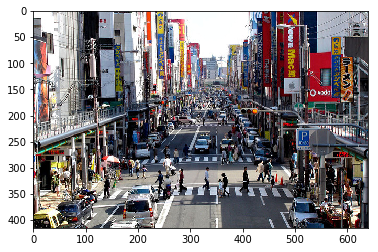

In [29]:
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
plt.imshow(image)
plt.show()

## Test the pre-trained model

We now call the `detect` function of the model on the list of images we want to be segmented. This returns a `result` object; inspect this object to see what it contains.

The `visualize` helper module provides useful functions to visualize our segmentation results. Understand how this function works (SHIFT+TAB in Jupyter is useful, as well as looking at the code in `visualize.py` directly).

Processing 1 images
image                    shape: (415, 640, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000
CPU times: user 1.72 s, sys: 0 ns, total: 1.72 s
Wall time: 2.15 s


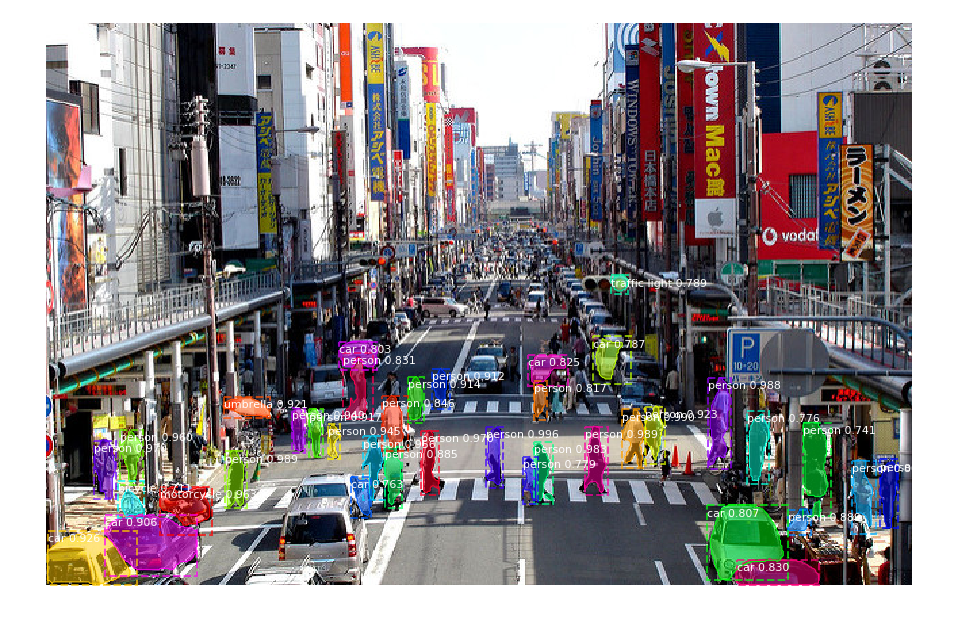

In [30]:
%%time
results = model.detect([image], verbose=1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Training from scratch

Now that we understand what a properly trained model should do, we consider training a model from scratch.

## Load the data

Load the annotations for the training images into memory.

In [31]:
%%time
config = coco.CocoConfig()
COCO_DIR = "2014"
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "minival")
dataset.prepare()

loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
CPU times: user 660 ms, sys: 0 ns, total: 660 ms
Wall time: 651 ms


Now load the same for the test images.

In [32]:
%%time
dataset_val = coco.CocoDataset()
dataset_val.load_coco(COCO_DIR, "val35k")
dataset_val.prepare()

loading annotations into memory...
Done (t=4.53s)
creating index...
index created!
CPU times: user 5.94 s, sys: 0 ns, total: 5.94 s
Wall time: 5.89 s


## List a few object classes

In [33]:
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))
    if i > 10:
        break

Image Count: 4952
Class Count: 81
  0. BG                                                
  1. person                                            
  2. bicycle                                           
  3. car                                               
  4. motorcycle                                        
  5. airplane                                          
  6. bus                                               
  7. train                                             
  8. truck                                             
  9. boat                                              
 10. traffic light                                     
 11. fire hydrant                                      


## Visualize a random image and its annotations

image_id  2152 http://cocodataset.org/#explore?id=396729
image                    shape: (425, 640, 3)         min:    0.00000  max:  223.00000
mask                     shape: (425, 640, 5)         min:    0.00000  max:    1.00000
class_ids                shape: (5,)                  min:   46.00000  max:   74.00000
bbox                     shape: (5, 4)                min:    0.00000  max:  639.00000


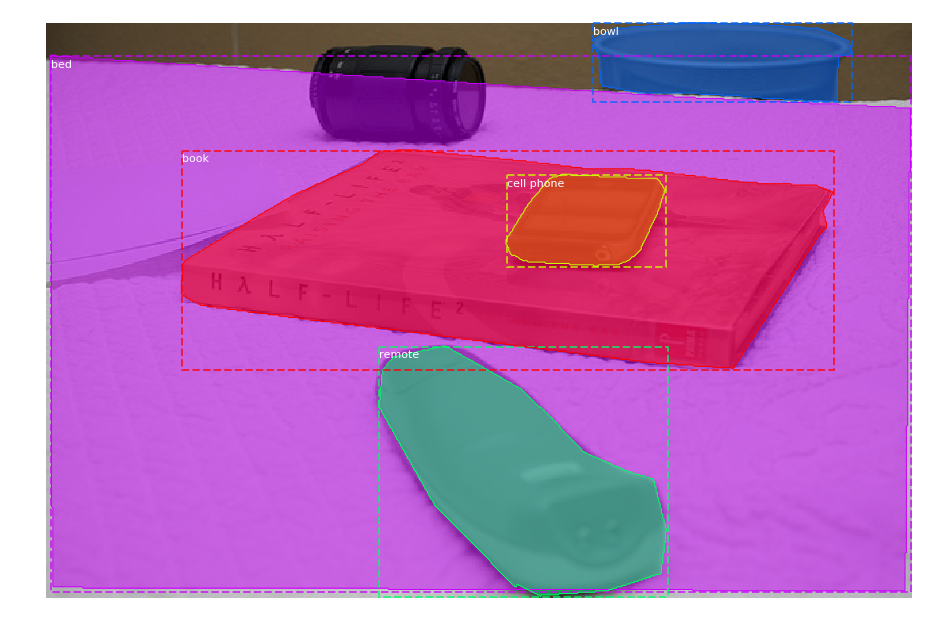

In [34]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Training configuration

See the default configuration values in `config.py`.

In [35]:
class TrainConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 60

config = TrainConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.002
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINI

## Create a new model in training mode 

In [36]:
# Create model in training mode

model_new = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

## Initialize the model weights with the weights learned on COCO 

Call `load_weights` as before, but add the following argument in the call to the function:

```
exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"]
```

In [37]:
# your code here
model_new.load_weights(COCO_MODEL_PATH, by_name=True,exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
          "mrcnn_bbox", "mrcnn_mask"])

## Train the model for 10 epochs 

Look up the documentation or code for the train function to figure out its arguments.

Pass the following additional arguments to the `train` function:

   - `layers="heads"` to only train the weights that were not pre-loaded.
   - `learning_rate=config.LEARNING_RATE` to set the learning rate.
   - `epochs=10`.
   
This will take ~10 minutes on a p2.xlarge GPU instance with 1 GPU.

In [38]:
%%time
# call to train
model_new.train(dataset, dataset_val, layers='heads',  learning_rate=config.LEARNING_RATE,   epochs=10 )

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)



Starting at epoch 0. LR=0.002

Checkpoint Path: /home/ubuntu/HW3/logs/coco20171205T2109/mask_rcnn_coco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
60/60 [==============================] - 90s 2s/step - loss: 3.5565 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 1.5682 - mrcnn_bbox_loss: 0.8358 - mrcnn_mask_loss: 0.8284 - val_loss: 2.1179 - val_rpn_class_loss: 1.5053e-04 - val_rpn_bbox_loss: 0.1180 - val_mrcnn_class_loss: 0.3293 - val_mrcnn_bbox_loss: 0.8726 - val_mrcnn_mask_loss: 0.7979
Epoch 2/10
60/60 [==============================] - 57s 955ms/step - loss: 2.4679 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.3756 - mrcnn_class_loss: 0.8805 - mrcnn_bbox_loss: 0.6132 - mrcnn_mask_loss: 0.5741 - val_loss: 1.9696 - val_rpn_class_loss: 2.4458e-04 - val_rpn_bbox_loss: 0.1921 - val_mrcnn_class_loss: 0.2061 - val_mrcnn_bbox_loss: 0.8164 - val_mrcnn_mask_loss: 0.7547
Epoch 3/10
60/60 [==============================] - 57s 958ms/step - loss: 2.2760 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.3452 - mrcnn_class_loss: 0.7646 - mrcnn_bbox_loss: 0.5866 - mrcnn_mask_loss: 0.5649 - val_loss: 1.5727 - val_rpn_cl

## Test model 

Load the model in inference (testing) mode.

In [39]:
# load model

class InferenceConfig(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreating the model in inference mode
model_inf = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

Load the last trained model weights.

In [40]:
model_path = model_inf.find_last()[1] # use the last trained weights
model_inf.load_weights(model_path, by_name=True)

Visualize the true annotations of a random test image.

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (89,)                 min:    0.00000  max: 25503.00000
gt_class_id              shape: (13, 4)               min:  192.00000  max:  842.00000
gt_bbox                  shape: (13, 4)               min:  192.00000  max:  842.00000
gt_mask                  shape: (1024, 1024, 13)      min:    0.00000  max:    1.00000


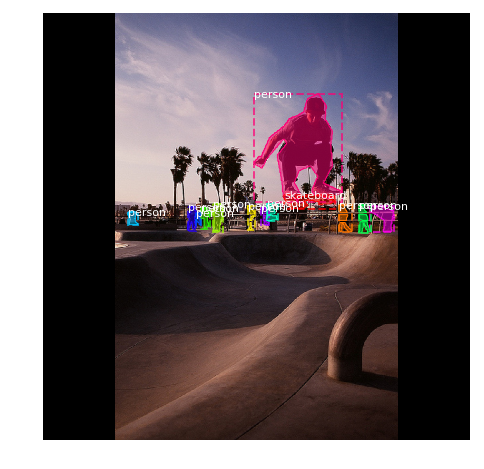

In [41]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Visualize the predicted annotations for this image

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.10000
image_metas              shape: (1, 89)               min:    0.00000  max: 1024.00000


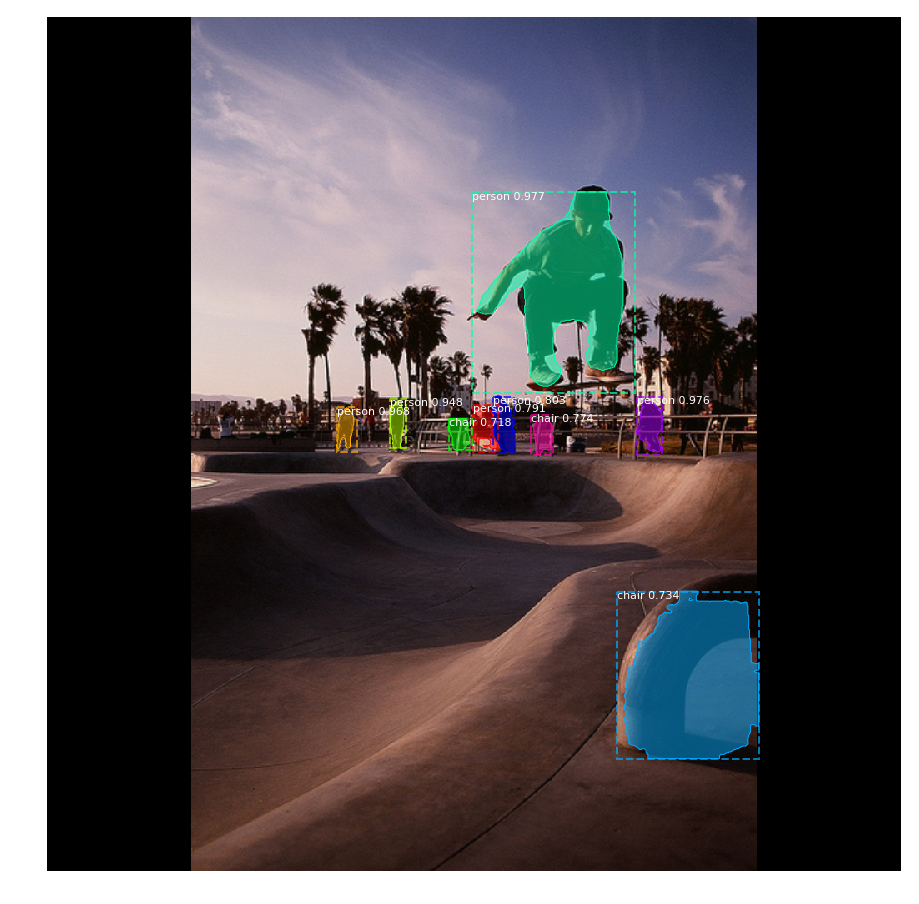

In [42]:
# predicted annotations visualization
result = model_inf.detect([original_image], verbose=1)

p = result[0]
visualize.display_instances(original_image, p['rois'], p['masks'], p['class_ids'], 
                            dataset_val.class_names, p['scores'])